In [1]:
import sys, os, imp
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c
from scipy.signal import find_peaks

C:\Users\alves\AppData\Local\Temp\ipykernel_17336\1292900171.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import sys, os, imp


In [2]:
lumapiFile = "/opt/lumerical/v221/api/python/lumapi.py"
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
lumapi = imp.load_source("lumapi", lumapiFile)
interApi = lumapi.INTERCONNECT(hide = False)
interApi.expressioncheckoff()

In [3]:
# Function to create decices
def add_elements(order:int, lengths:dict, names:dict, L, delta_L:float, delta_L_shift:float, L_pi:float):
    for i in range(1, order+2):
        interApi.addelement('ebeam_dc_te1550')
        interApi.set('name', names[f'coupler_{i}'])
        if (order == 2 and i == 2):
            interApi.set('coupling_length', lengths['L29'])
        elif (order == 2 and i == 3):
            interApi.set('coupling_length', lengths['L8'])
        elif (order == 3 and (i == 2 or i == 3)):
            interApi.set('coupling_length', lengths['L20'])
        elif (order == 3 and (i == 4)):
            interApi.set('coupling_length', lengths['L4'])
        else:
            interApi.set('coupling_length', lengths['L50'])

    for i in range(0, order*2):
        interApi.addelement('ebeam_wg_integral_1550')
        interApi.set('name',  names[f'wg_{i+1}'])
        if (i == 1 or i == 2 or i == 4):
            interApi.set('wg_length', L)
        elif (order != 1 and i == 3):
            interApi.set('wg_length', L + 2*delta_L + 2*delta_L_shift)
        elif (order == 3 and i == 5):
            interApi.set('wg_length', L + delta_L + delta_L_shift + L_pi)
        else:
            interApi.set('wg_length', L + delta_L + delta_L_shift)

In [4]:
# Function to draw the photonic circuit

def desing_filter(order:int, lengths:dict, L:float, delta_L:float, delta_L_shift:float, L_pi:float, name_prefix:str, position_x:float, position_y:float): 
    
    interApi.switchtolayout()

    # Create device names
    names = {}
    for i in range(1, order+2):
        names[f'coupler_{i}'] = f'{name_prefix}_coupler_{i}'
    for i in range(order*2):
        names[f'wg_{i+1}'] = f'{name_prefix}_wg_{i+1}'

    # Removes existing elements with the same names
    for element in names.values():
        interApi.select(element)
        interApi.delete()

    # Add elements
    add_elements(order, lengths, names, L, delta_L, delta_L_shift, L_pi)

    # positions
    for i in range(1, order+2):
        interApi.setposition(names[f'coupler_{i}'], 300*i + position_x, 50 + position_y)
    for i in range(1, order + 1):
        x_wg = (300 * i + 300 * (i + 1)) / 2 + position_x  
        interApi.setposition(names[f'wg_{i*2-1}'], x_wg, -150 + position_y)
        interApi.setposition(names[f'wg_{i*2}'], x_wg, 150 + position_y)

    # connection
    for i in range(1, order+1):
        interApi.connect(names[f'coupler_{i}'], "opt_3", names[f'wg_{2*i-1}'], "port 1")
        interApi.connect(names[f'coupler_{i}'], "opt_4", names[f'wg_{2*i}'], "port 1")
        interApi.connect(names[f'wg_{2*i-1}'], "port 2", names[f'coupler_{i+1}'], "opt_1")
        interApi.connect(names[f'wg_{2*i}'], "port 2", names[f'coupler_{i+1}'], "opt_2")

    return names  # returns the names of the elements for external control

In [5]:
# Funtion to connect the devices

def connections(st1_A:dict, st1_B:dict, st1_C:dict, st1_D:dict, st2_A:dict, st2_B:dict, st3:dict, orders:list):
    interApi.connect("ONA", "output", st3['coupler_1'] , "opt_2")


    interApi.connect(st3[f'coupler_{orders[0]+1}'], "opt_3", st2_A['coupler_1'], "opt_2")
    interApi.connect(st3[f'coupler_{orders[0]+1}'], "opt_4", st2_B['coupler_1'], "opt_1")

    interApi.connect(st2_A[f'coupler_{orders[1]+1}'], "opt_3", st1_A['coupler_1'], "opt_2")
    interApi.connect(st2_A[f'coupler_{orders[1]+1}'], "opt_4", st1_B['coupler_1'], "opt_1")
    interApi.connect(st2_B[f'coupler_{orders[2]+1}'], "opt_3", st1_C['coupler_1'], "opt_2")
    interApi.connect(st2_B[f'coupler_{orders[2]+1}'], "opt_4", st1_D['coupler_1'], "opt_1")

    interApi.connect(st1_A[f'coupler_{orders[3]+1}'], "opt_3", "ONA", "input 1")
    interApi.connect(st1_A[f'coupler_{orders[3]+1}'], "opt_4", "ONA", "input 5")
    interApi.connect(st1_B[f'coupler_{orders[4]+1}'], "opt_3", "ONA", "input 7")
    interApi.connect(st1_B[f'coupler_{orders[4]+1}'], "opt_4", "ONA", "input 3")
    interApi.connect(st1_C[f'coupler_{orders[5]+1}'], "opt_3", "ONA", "input 2")
    interApi.connect(st1_C[f'coupler_{orders[5]+1}'], "opt_4", "ONA", "input 6")
    interApi.connect(st1_D[f'coupler_{orders[6]+1}'], "opt_3", "ONA", "input 8")
    interApi.connect(st1_D[f'coupler_{orders[6]+1}'], "opt_4", "ONA", "input 4")

In [118]:
# Function plot gain

def plot_gain(gain_1:dict, gain_2:dict, gain_3:dict, gain_4:dict, gain_5:dict, gain_6:dict, gain_7:dict, gain_8:dict, name:str, freq:float):

    fig, axs = plt.subplots(2, 2, figsize=(25, 15))

    gains = [gain_1, gain_2, gain_3, gain_4, gain_5, gain_6, gain_7, gain_8]

    for gain, i in zip(gains, range(1, 9)):
        axs[0, 0].plot(gain['wavelength']/nm , gain["'TE' gain (dB)"], lw=1, label=f'$\lambda$ {i}')
    axs[0, 0].plot([wvlngth_start/nm, wvlngth_stop/nm], [-3, -3], label='-3dB', ls='--', color='black')
    axs[0, 0].set_xlabel('$\lambda$ (nm)')
    axs[0, 0].set_ylabel('Gain (dB)')
    axs[0, 0].set_xlim([wvlngth_start/nm, wvlngth_stop/nm])
    axs[0, 0].set_ylim([-40, 2])
    # axs[0, 0].set_title(f'CWDM {name}-order Filters (PDK SiEPIC {freq}GHz)')
    axs[0, 0].minorticks_on()
    axs[0, 0].grid(which='both', linestyle='--', linewidth=0.5)  
    axs[0, 0].grid(which='minor', linestyle=':', linewidth=0.5) 
    axs[0, 0].legend(loc='lower right', fontsize=15)

    for gain, i in zip(gains, range(1, 9)):
        axs[0, 1].plot(gain['wavelength']/nm , gain["'TE' gain (dB)"], lw=1, label=f'$\lambda$ {i}')
    xticks = [1544.53, 1544.92, 1545.32, 1545.72, 1546.12, 1546.52, 1546.92, 1547.32, 1547.72, 1548.11, 1548.52, 1548.91, 1549.32]
    channels = [41, 40.5, 40, 39.5, 39, 38.5, 38, 37.5, 37, 36.5, 36, 35.5, 35]
    for i, j in zip(xticks, channels):
            axs[0, 1].plot([i, i], [-4, 1], ls=':', color='black')
            axs[0, 1].text(i+0.05, -1.8, f'Channel {j}', rotation=90, fontsize=15)
    axs[0, 1].set_xlabel('$\lambda$ (nm)')
    axs[0, 1].set_ylabel('Gain (dB)')
    axs[0, 1].hlines(y=-3, xmin=wvlngth_start/nm, xmax=wvlngth_stop/nm, colors='black', ls='--')
    # axs[0, 1].set_title(f'CWDM {name}-order Filters (PDK SiEPIC {freq}GHz)')
    axs[0, 1].minorticks_on()
    axs[0, 1].grid(which='both', linestyle='--', linewidth=0.5)  
    axs[0, 1].grid(which='minor', linestyle=':', linewidth=0.5) 
    axs[0, 1].set_xticks(xticks)
    axs[0, 1].set_xlim([xticks[0]-0.4, xticks[-1]+0.4])
    axs[0, 1].set_ylim([-4, 0.5])
    axs[0, 1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=15)

    # Insertion Loss
    powers = [10**(gain["'TE' gain (dB)"] / 10) for gain in gains]
    total_power = np.sum(powers, axis=0)
    il = 10 * np.log10(total_power)
    axs[1, 0].plot(gains[0]['wavelength']/nm, il, lw=1, label='Insertion Loss')
    axs[1, 0].hlines(y=np.mean(il), xmin=wvlngth_start/nm, xmax=wvlngth_stop/nm, colors='black', ls='--', label=f'Average Insertion Loss: {np.mean(il):.2f} dB')
    # axs[1, 0].set_title('Insertion Loss')
    axs[1, 0].set_xlabel('$\lambda$ (nm)')
    axs[1, 0].set_ylabel('Loss (dB)')
    axs[1, 0].minorticks_on()
    axs[1, 0].grid(which='both', linestyle='--', linewidth=0.5)  
    axs[1, 0].grid(which='minor', linestyle=':', linewidth=0.5) 
    axs[1, 0].set_xlim([wvlngth_start/nm, wvlngth_stop/nm])
    # axs[1, 0].set_ylim([-4, 0.5])
    axs[1, 0].legend(loc='best', fontsize=15)

    
    
    axs[1, 1].plot(gain_4['wavelength']/nm , gain_4["'TE' gain (dB)"], color='r', lw=1, label=f'$\lambda$ 4')
    xticks = np.array([1546.92])
    for i in xticks:
            axs[1, 1].plot([i, i], [-4.5, 1], ls=':', color='black')
    axs[1, 1].set_xlabel('$\lambda$ (nm)')
    axs[1, 1].set_ylabel('Gain (dB)')
    axs[1, 1].hlines(y=-3, xmin=xticks[0]-0.2, xmax=xticks[-1]+0.2, colors='black', ls='--')
    # axs[1, 1].set_title(f'CWDM {name}-order Filters (PDK SiEPIC {freq}GHz)')
    axs[1, 1].minorticks_on()
    axs[1, 1].grid(which='both', linestyle='--', linewidth=0.5)  
    axs[1, 1].grid(which='minor', linestyle=':', linewidth=0.5) 
    axs[1, 1].set_xticks(xticks)
    axs[1, 1].set_xlim([xticks[0]-0.2, xticks[-1]+0.2])
    axs[1, 1].set_ylim([-4.5, 0])
    axs[1, 1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=15)
    
    fig.suptitle(f'CWDM PDk SiEPIC {freq} GHz - {name}', fontsize=20)
    plt.savefig(f'CWDM_Optimization_{name}', bbox_inches='tight')
    plt.show()

In [7]:
# units
um = 1e-6
nm = 1e-9

# index
# neff = 2.3531702
# ng = 4.3458796

# index PDK
neff = 2.44553
ng = 4.19088

wvlngth_start = 1530 * nm
wvlngth_stop = 1565 * nm
center_wvlg = 1550 * nm

number_of_points = 50e3

In [8]:
interApi.switchtolayout()
interApi.select('ONA')
interApi.delete()

# ONA

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.set('number of input ports', 8)
interApi.set('input parameter', 2)
interApi.set('start frequency', c/wvlngth_start)
interApi.set('stop frequency', c/wvlngth_stop)
interApi.set('number of points', number_of_points)

interApi.setposition('ONA', -500, -1800)


In [9]:
# Filter parameters
FSR = 2*0.4*nm # 50GHz
center_wvlg = 1550.02 * nm
delta_L = center_wvlg**2 / (ng*FSR)
L = 5*um

delta_L_fs = center_wvlg/neff
L_pi = center_wvlg/(2*neff)

In [10]:
lengths = {
    'L50': 17.5*um,
    'L29': 12.5*um,
    'L20': 10.0*um,
    'L8':   5.0*um,
    'L4':   2.5*um
}

# Original Filter

In [127]:
# First Stage
st3 = desing_filter(order=2, lengths=lengths, L=L, delta_L=delta_L, delta_L_shift=0, L_pi=0, name_prefix='st3', position_x=-2000, position_y=-500)

In [128]:
# Second Stage
st2_A = desing_filter(order=2, lengths=lengths, L=L, delta_L=0.5*delta_L, delta_L_shift=0, L_pi=0, name_prefix='st2_A', position_x=-1000, position_y=-900)
st2_B = desing_filter(order=2, lengths=lengths, L=L, delta_L=0.5*delta_L, delta_L_shift=0.75*delta_L_fs, L_pi=0, name_prefix='st2_B', position_x=-1000, position_y=-100)

In [129]:
# Third Stage
st1_A = desing_filter(order=2, lengths=lengths, L=L, delta_L=0.25*delta_L, delta_L_shift=0, L_pi=0, name_prefix='st1_A', position_x=0, position_y=-1200)
st1_B = desing_filter(order=2, lengths=lengths, L=L, delta_L=0.25*delta_L, delta_L_shift=0.25*delta_L_fs, L_pi=0, name_prefix='st1_B', position_x=0, position_y=-800)
st1_C = desing_filter(order=2, lengths=lengths, L=L, delta_L=0.25*delta_L, delta_L_shift=0.125*delta_L_fs, L_pi=0, name_prefix='st1_C', position_x=0, position_y=-400)
st1_D = desing_filter(order=2, lengths=lengths, L=L, delta_L=0.25*delta_L, delta_L_shift=0.375*delta_L_fs, L_pi=0, name_prefix='st1_D', position_x=0, position_y=0)

In [130]:
                                                           #orders = [st3, st2A, st2B, st1A, st1B, st1C, st1D
connections(st1_A, st1_B, st1_C, st1_D, st2_A, st2_B, st3,  orders=   [2,     2,    2,    2,    2,    2,    2])

In [131]:
interApi.run()

In [132]:
gain_1 = interApi.getresult("ONA", "input 1/mode 1/gain")
gain_2 = interApi.getresult("ONA", "input 2/mode 1/gain")
gain_3 = interApi.getresult("ONA", "input 3/mode 1/gain")
gain_4 = interApi.getresult("ONA", "input 4/mode 1/gain")
gain_5 = interApi.getresult("ONA", "input 5/mode 1/gain")
gain_6 = interApi.getresult("ONA", "input 6/mode 1/gain")
gain_7 = interApi.getresult("ONA", "input 7/mode 1/gain")
gain_8 = interApi.getresult("ONA", "input 8/mode 1/gain")

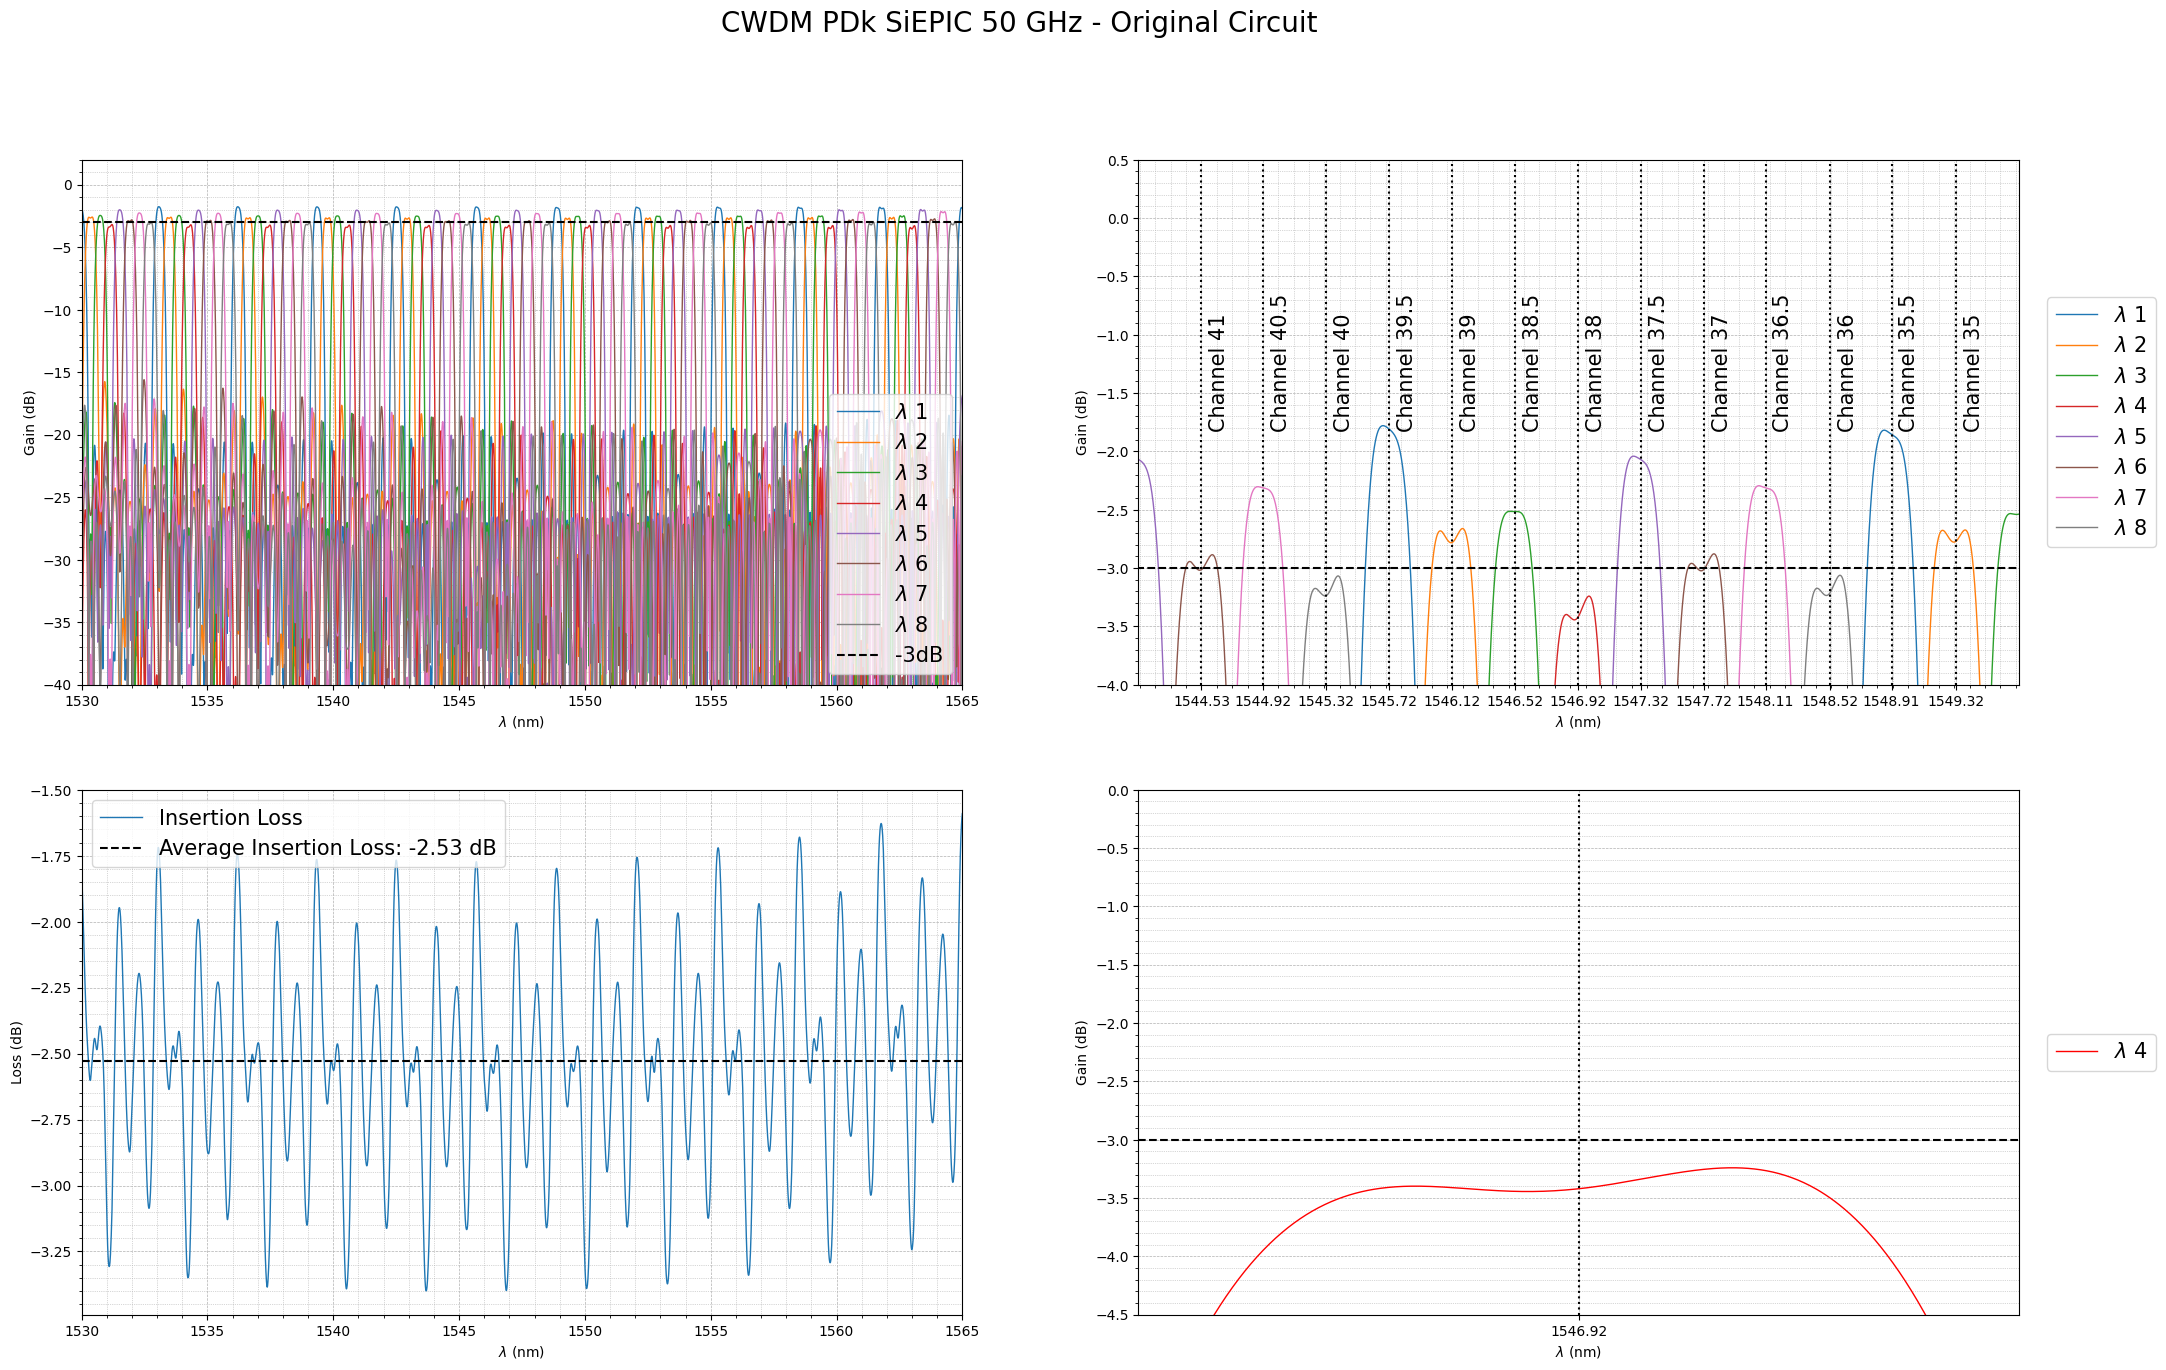

In [133]:
plot_gain(gain_1, gain_2, gain_3, gain_4, gain_5, gain_6, gain_7, gain_8, 'Original Circuit', 50)

# Optimized Filter 01


In [120]:
# First Stage
st3 = desing_filter(order=2, lengths=lengths, L=L, delta_L=delta_L, delta_L_shift=0, L_pi=0, name_prefix='st3', position_x=-2000, position_y=-500)

In [121]:
# Second Stage
st2_A = desing_filter(order=2, lengths=lengths, L=L, delta_L=0.5*delta_L, delta_L_shift=0, L_pi=0, name_prefix='st2_A', position_x=-1000, position_y=-900)
st2_B = desing_filter(order=1, lengths=lengths, L=L, delta_L=0.5*delta_L, delta_L_shift=0.75*delta_L_fs, L_pi=0, name_prefix='st2_B', position_x=-1000, position_y=-100)

In [122]:
# Third Stage
st1_A = desing_filter(order=2, lengths=lengths, L=L, delta_L=0.25*delta_L, delta_L_shift=0, L_pi=0, name_prefix='st1_A', position_x=0, position_y=-1200)
st1_B = desing_filter(order=1, lengths=lengths, L=L, delta_L=0.25*delta_L, delta_L_shift=0.25*delta_L_fs, L_pi=0, name_prefix='st1_B', position_x=0, position_y=-800)
st1_C = desing_filter(order=1, lengths=lengths, L=L, delta_L=0.25*delta_L, delta_L_shift=0.125*delta_L_fs, L_pi=0, name_prefix='st1_C', position_x=0, position_y=-400)
st1_D = desing_filter(order=1, lengths=lengths, L=L, delta_L=0.25*delta_L, delta_L_shift=0.375*delta_L_fs, L_pi=0, name_prefix='st1_D', position_x=0, position_y=0)

In [123]:
                                                           #orders = [st3, st2A, st2B, st1A, st1B, st1C, st1D
connections(st1_A, st1_B, st1_C, st1_D, st2_A, st2_B, st3,  orders=   [2,     2,    1,    2,    1,    1,    1])

In [124]:
interApi.run()

In [125]:
gain_1 = interApi.getresult("ONA", "input 1/mode 1/gain")
gain_2 = interApi.getresult("ONA", "input 2/mode 1/gain")
gain_3 = interApi.getresult("ONA", "input 3/mode 1/gain")
gain_4 = interApi.getresult("ONA", "input 4/mode 1/gain")
gain_5 = interApi.getresult("ONA", "input 5/mode 1/gain")
gain_6 = interApi.getresult("ONA", "input 6/mode 1/gain")
gain_7 = interApi.getresult("ONA", "input 7/mode 1/gain")
gain_8 = interApi.getresult("ONA", "input 8/mode 1/gain")

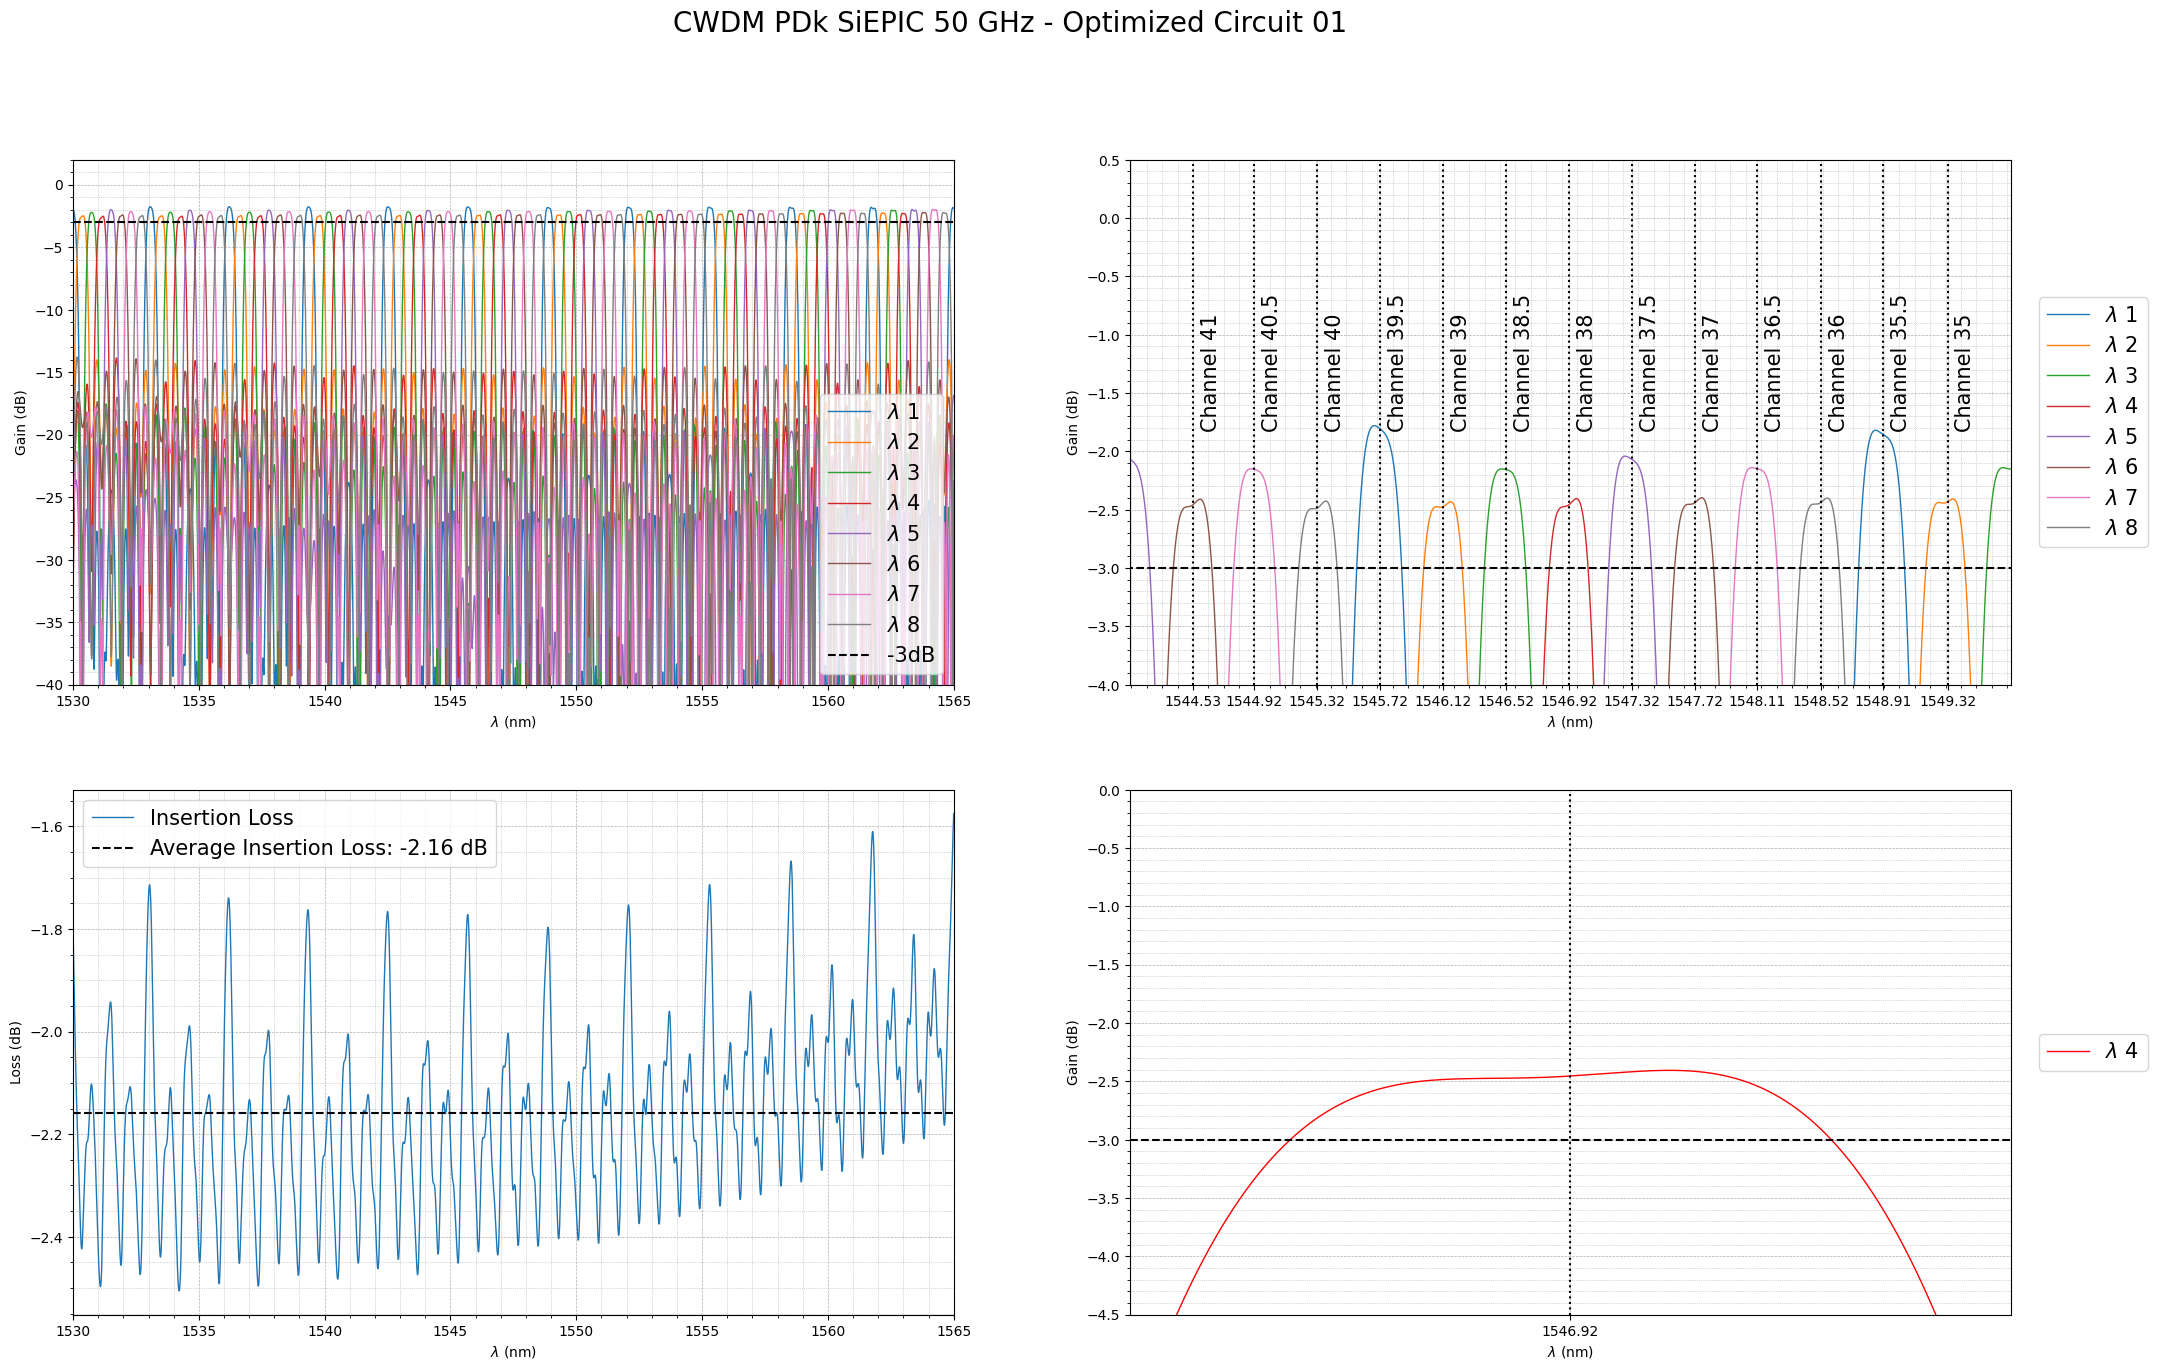

In [126]:
plot_gain(gain_1, gain_2, gain_3, gain_4, gain_5, gain_6, gain_7, gain_8, 'Optimized Circuit 01', 50)

# Optimized Filter 02

In [99]:
# First Stage
st3 = desing_filter(order=2, lengths=lengths, L=L, delta_L=delta_L, delta_L_shift=0, L_pi=0, name_prefix='st3', position_x=-2000, position_y=-500)

In [100]:
# Second Stage
st2_A = desing_filter(order=1, lengths=lengths, L=L, delta_L=0.5*delta_L, delta_L_shift=0, L_pi=0, name_prefix='st2_A', position_x=-1000, position_y=-900)
st2_B = desing_filter(order=1, lengths=lengths, L=L, delta_L=0.5*delta_L, delta_L_shift=0.75*delta_L_fs, L_pi=0, name_prefix='st2_B', position_x=-1000, position_y=-100)

In [101]:
# Third Stage
st1_A = desing_filter(order=1, lengths=lengths, L=L, delta_L=0.25*delta_L, delta_L_shift=0, L_pi=0, name_prefix='st1_A', position_x=0, position_y=-1200)
st1_B = desing_filter(order=1, lengths=lengths, L=L, delta_L=0.25*delta_L, delta_L_shift=0.25*delta_L_fs, L_pi=0, name_prefix='st1_B', position_x=0, position_y=-800)
st1_C = desing_filter(order=1, lengths=lengths, L=L, delta_L=0.25*delta_L, delta_L_shift=0.125*delta_L_fs, L_pi=0, name_prefix='st1_C', position_x=0, position_y=-400)
st1_D = desing_filter(order=1, lengths=lengths, L=L, delta_L=0.25*delta_L, delta_L_shift=0.375*delta_L_fs, L_pi=0, name_prefix='st1_D', position_x=0, position_y=0)

In [102]:
                                                           #orders = [st3, st2A, st2B, st1A, st1B, st1C, st1D
connections(st1_A, st1_B, st1_C, st1_D, st2_A, st2_B, st3,  orders=   [2,     1,    1,    1,    1,    1,    1])

In [103]:
interApi.run()

In [104]:
gain_1 = interApi.getresult("ONA", "input 1/mode 1/gain")
gain_2 = interApi.getresult("ONA", "input 2/mode 1/gain")
gain_3 = interApi.getresult("ONA", "input 3/mode 1/gain")
gain_4 = interApi.getresult("ONA", "input 4/mode 1/gain")
gain_5 = interApi.getresult("ONA", "input 5/mode 1/gain")
gain_6 = interApi.getresult("ONA", "input 6/mode 1/gain")
gain_7 = interApi.getresult("ONA", "input 7/mode 1/gain")
gain_8 = interApi.getresult("ONA", "input 8/mode 1/gain")

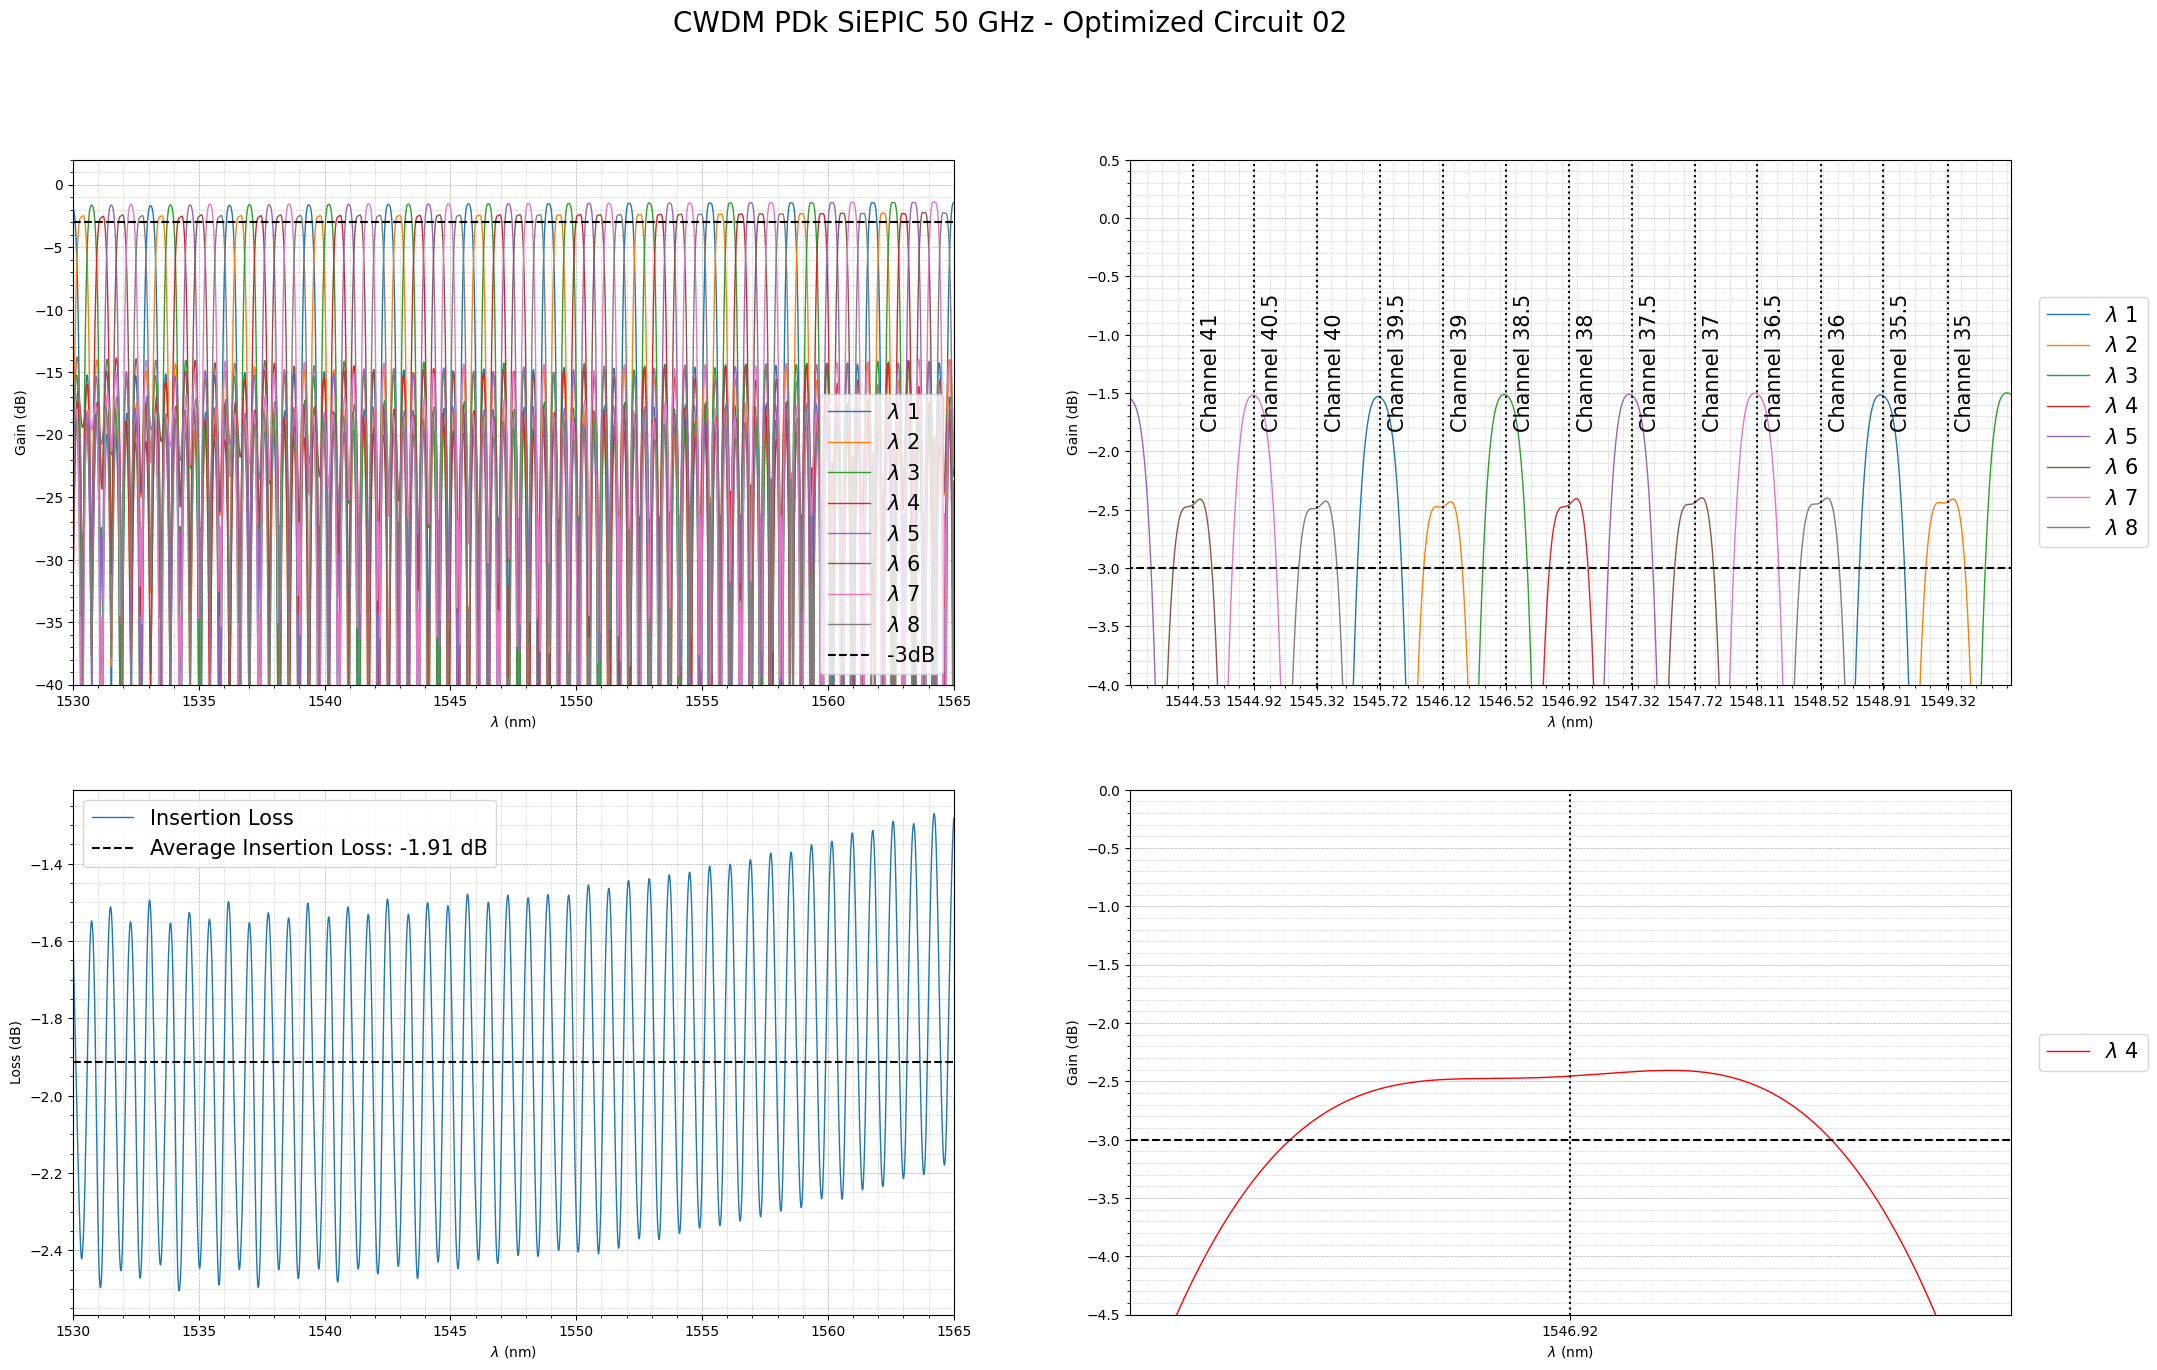

In [119]:
plot_gain(gain_1, gain_2, gain_3, gain_4, gain_5, gain_6, gain_7, gain_8, 'Optimized Circuit 02', 50)

# Define coupling lenghts

In [ ]:
# Function to determine the correct coupling lengths for each D.C.
def coupling(length):
    L_array = np.array([])
    dif_array_50 = np.array([])
    dif_array_29 = np.array([])
    dif_array_8 = np.array([])

    target_29 = 10*np.log10(0.22)
    target_8 = 10*np.log10(0.04) 

    for L in length:
        interApi.switchtolayout()
        interApi.select('coupler')
        interApi.set('coupling_length', L)

        interApi.run()
        input_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
        input_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')

        gain_1 = input_1["'TE' gain (dB)"]
        gain_2 = input_2["'TE' gain (dB)"]

        L_array = np.append(L_array, L)
        dif_array_50 = np.append(dif_array_50, np.mean(np.abs(gain_1-gain_2)))
        dif_array_29 = np.append(dif_array_29, np.mean(np.abs(gain_1-target_29)))
        dif_array_8 = np.append(dif_array_8, np.mean(np.abs(gain_1-target_8)))

    idx_50 = dif_array_50.argmin()
    idx_29 = dif_array_29.argmin()
    idx_8 = dif_array_8.argmin()

    print(f"Coupling length to 50% : {L_array[idx_50]/um}um\n"   
            f"Coupling length to 20%: {L_array[idx_29]/um}um\n" 
            f"Coupling length to 4%: {L_array[idx_8]/um}um")

In [ ]:
interApi.switchtolayout()
interApi.select('coupler')
interApi.delete()


interApi.addelement('ebeam_dc_te1550')
interApi.set('name', 'coupler')

interApi.connect('ONA', 'output', 'coupler', 'opt_2')
interApi.connect('ONA', 'input 1', 'coupler', 'opt_3')
interApi.connect('ONA', 'input 2', 'coupler', 'opt_4')

1.0

In [ ]:
length = np.arange(0, 50, 2.5) * um
coupling(length)

Coupling length to 50% : 17.5um
Coupling length to 20%: 10.0um
Coupling length to 4%: 2.5um
